Import all the libraries that are necessary 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
from sklearn import svm
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import zipfile
import os
import ntpath
from os.path import isfile, isdir
from urllib.request import urlretrieve
%matplotlib inline

In [2]:
# Create an output directory in case it does not exist
if not os.path.exists("output_images"):
    os.makedirs("output_images")


The following is the code to download and extract the training data if it is not on the current system.

In [3]:
car = "vehicles.zip"
noncar = "non-vehicles.zip"

carpath = "car"
noncarpath = "noncar"

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(car):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Car data') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip',
            car,
            pbar.hook)
if not isfile(noncar):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Non-car data') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip',
            noncar,
            pbar.hook)

if not isdir(carpath):
    zipcar = zipfile.ZipFile(car, 'r')
    zipcar.extractall(carpath)
    zipcar.close()
    
if not isdir(noncarpath):
    zipnoncar = zipfile.ZipFile(noncar, 'r')
    zipnoncar.extractall(noncarpath)
    zipnoncar.close()
    


Now we have the training data on our computer, we need to read them and put them onto a python list to identify rather they are cars or non-cars. The following code do exactly this. But for now, the following only read the name of the image files and then randomize them.

In [4]:
import glob
from random import shuffle

def ReadImages(car_imgs, carlist):
    for car_img in car_imgs:
        carlist.append(car_img)

cars = []
notcars = []

car_images = glob.glob('car/vehicles/GTI_Far/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/GTI_Left/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/GTI_MiddleClose/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/GTI_Right/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/KITTI_extracted/*.png')
ReadImages(car_images, cars)


car_images = glob.glob('noncar/non-vehicles/GTI/*.png')
ReadImages(car_images, notcars)
car_images = glob.glob('noncar/non-vehicles/Extras/*.png')
ReadImages(car_images, notcars)

shuffle(cars)
shuffle(notcars)


The following defined three functions: namely, bin_spatial, color_hist, get_hog_features, and extract_features.

bin_spatial:

This is used as reading the image color contents or to read the spatial features. If the "size" input is None (by default), then it is used as reading the image color contents. Otherwise, it will be used as binary spatial function.

color_hist:

This function get the color histogram. the default bin size is 32. I have tried a few tests and look like this properties for detecting a car have very small impact for the classifier. I will not use it. Just keep it here for now in case I want to test on something else.

get_hog_features:

Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images. I provided the default inputs for orient, pix_per_cell, cell_per_block, and vis.

extract_features:

This function, basically read a list of image names, and then read the actual content of the images, and extract the spatial and Histogram of Oriented Gradients features. 

I did not use the color histogram because the impact for the classifier is very small that it does not contribute to important car detection decision. Especially when we are on the road where there is shadow from the tree or bad lighting condition.

In [5]:
from skimage.feature import hog

def bin_spatial(img, color_space='RGB', size=None):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)
            # Use cv2.resize().ravel() to create the feature vector
    if size != None:
        features = cv2.resize(feature_image, size).ravel()
    else:
        features = feature_image
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    fhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range) #First channel histogram
    shist = np.histogram(img[:,:,1], bins=nbins, range=bins_range) # Second channel histogram
    thist = np.histogram(img[:,:,2], bins=nbins, range=bins_range) # Third channel histogram
    bin_edges = fhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return np.concatenate((fhist[0], shist[0], thist[0]))

def get_hog_features(img, orient = 7, pix_per_cell = 8, cell_per_block = 2, vis=False):
    if vis == True:
        features, hog_img = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=True, feature_vector=False)
        return features, hog_img
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=False, feature_vector=True)
        return features

def extract_features(imgs, spatial, histogram, HOG, color_space='RGB', hog_channel='ALL'):
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        feature_image = bin_spatial(image, color_space=color_space)
        f = []
        
        if spatial:
            f.append( bin_spatial(feature_image, color_space='RGB', size=(32, 32)) )
        
        if histogram:
            f.append( color_hist(feature_image) )

        if HOG:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel]))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel])
            f.append(hog_features)

        
        # Append the new feature vector to the features list
        features.append(np.concatenate(f))
    # Return list of feature vectors
    return features

The following ocde is used to train our model with SVM (support vector machine). Since the features is from both the HOG and image spatial features, we normalize the feature vector with StandardScalar() function. the variables, svc, X_scaler are used later for our prediction.

Lines 3 - 5 are the variables that determine what image features to used for our classifier. For this project, I disable color histogram since I think it has very little impact and it will simply slow down the car detection during real-time execution. In additional, the channel that we will be using for HOG is the "Blue" color channel.

In [6]:
import time

spatial = True
histogram = False
HOG = True

train_channel=2#'ALL'
t=time.time()
car_features = extract_features(cars, spatial, histogram, HOG, hog_channel=train_channel)
notcar_features = extract_features(notcars, spatial, histogram, HOG, hog_channel=train_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract images Spatial and HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


/Users/hiuchan/anaconda/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


30.17 Seconds to extract images Spatial and HOG features...
Feature vector length: 4444
16.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9741


We have 4444 features for this classifier and Accuracy is above 98%. I don't see any good reason why I would want to use color histogram and all of the color channels for HOG.

Sliding windows function:

This function do sliding windows on the image capture from the camera so that we can do prediction. The size of the area to slide in the image is by default a 64 x 64 square.

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 650], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


This is function that draw boxes on the image.

In [8]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

Two functions defined in the following. The single_img_features is almost identical to the extract_features function above. The only differnece is that it only handle one image.

The search_windows is function that detect possible car within the image frame. It call the slide_windows function above so that we have a set of windows defined to search for a car. Next, call the single_img_features for the associated windows and make the prediction. Of course, it is prediction only, it can be wrong.

In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images

def single_img_features(img, spatial, histogram, HOG, color_space='RGB', hog_channel='ALL'):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = bin_spatial(img, color_space=color_space)
    #3) Compute spatial features

    if spatial:
        img_features.append( bin_spatial(feature_image, color_space='RGB', size=(32, 32)) )

    if histogram:
        img_features.append( color_hist(feature_image) )

    if HOG:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel])) 
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel])
        img_features.append(hog_features)
    
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', hog_channel='ALL'):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, spatial, histogram, HOG, color_space=color_space, hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

There are three functions defined below. The ideal is we may detect false positive. But because our detection is above 98%, what we can do is slide the windows on the image, and see if the overlap regions is detected. This give us more confidence that the actual car is detected.

The add_heat function is simply adding one to the region where we identified a car within the region.

The apply_threshold function basically zero out the pixel of the image where the associated pixel value is below the threshold.

draw_label_bboxes draw the actual box where a car is detected. If the box is too small, we know it cannot be a car and therefore we just ignore it.

In [50]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold = 2):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, getbox=False):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if (bbox[1][0] - bbox[0][0]) > 50 and (bbox[1][1] - bbox[0][1]) > 50:
            # This if statement is to make sure the box is larger enought for us to believe it is a car.
            if getbox:
                boxes.append(bbox)
            else:
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    if getbox:
        return boxes
    else:
        return img


The following function "findcar" will do the actual detection for a car within a image. 

The idea is exactly same as what was described in the class material. Sliding windows detected a car through the entire image. There maybe true positive or false positive. However, we add up the detected rectangles and create a heatmap, and base on the intensity of the heatmap, we determine rather the region has a car ot not.

If the optional input parameter "vis" is set to "True", it will show the heatmap. 

If the optional input parameter "getbox" is set to "True", it will return a list of rectangle where we believe car is actually detected in the image. We set it to True for video so that we can buffer few video frames continuously and determine rather this is false positive or not. (more detail below).

I defined sliding windows with smaller windows on the middle of the image and larger windows to bottom part of the image since objects in front of a car camera are smaller where it is further away from our car and larger when it is closer to our car.

In [71]:
from scipy.ndimage.measurements import label

def findcar(image, svc, X_scaler, threshold, vis = False, getbox = False):
    h = np.zeros_like(image[:,:,0]).astype(np.float)

    draw_image = np.copy(image)
    image = image.astype(np.float32)/255

    # In the following, I defined few different size of windows at different region of the image.
    windows = slide_window(image, y_start_stop=[360, 630], xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows.extend(slide_window(image, x_start_stop=[200, 1080], y_start_stop=[360, 500], xy_window=(64, 64),
                                xy_overlap=(0.75, 0.75)))
    windows.extend(slide_window(image, y_start_stop=[360, 650], xy_window=(128, 128), xy_overlap=(0.75, 0.75)))
    windows.extend(slide_window(image, x_start_stop=[0, 400], y_start_stop=[400, 650], 
                                xy_window=(140, 140), xy_overlap=(0.8, 0.8)))
    windows.extend(slide_window(image, x_start_stop=[880, 1280], y_start_stop=[400, 650], 
                                xy_window=(140, 140), xy_overlap=(0.8, 0.8)))
    hot_windows = search_windows(image, windows, svc, X_scaler, hog_channel = train_channel)                       

    h = add_heat(h, hot_windows)
    
    # Apply threshold to help remove false positives
    h = apply_threshold(h, threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(h, 0, 255)
    
    if vis:
        plt.imshow(heatmap)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    output_img = draw_labeled_bboxes(draw_image, labels, getbox=getbox)
    return output_img

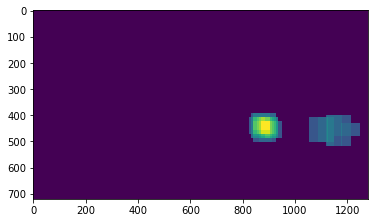

In [72]:
from PIL import Image

import os
import ntpath

# Create an output directory in case it does not exist
if not os.path.exists("output_images"):
    os.makedirs("output_images")
    
testthreshold = 3

detectcar = mpimg.imread('test_images/test1.jpg')
output_img = findcar(detectcar, svc, X_scaler, testthreshold, vis = True, getbox=True)

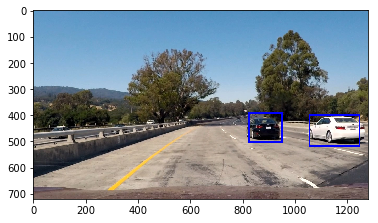

In [73]:
output_img = draw_boxes(detectcar, output_img)
plt.imshow(output_img)
im = Image.fromarray(output_img)
im.save("output_images/output1.jpg")

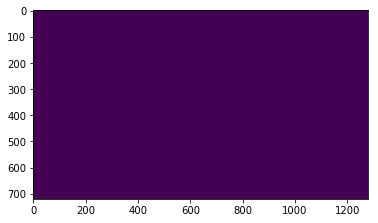

In [74]:
detectcar = mpimg.imread('test_images/test2.jpg')
output_img = findcar(detectcar, svc, X_scaler, testthreshold, vis = True, getbox=True)

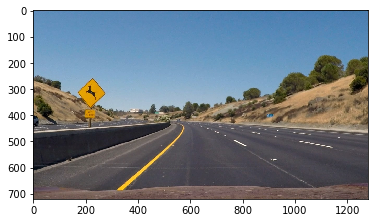

In [75]:
output_img = draw_boxes(detectcar, output_img)
plt.imshow(output_img)
im = Image.fromarray(output_img)
im.save("output_images/output2.jpg")

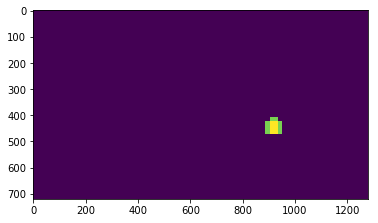

In [76]:
detectcar = mpimg.imread('test_images/test3.jpg')
output_img = findcar(detectcar, svc, X_scaler, testthreshold, vis = True)

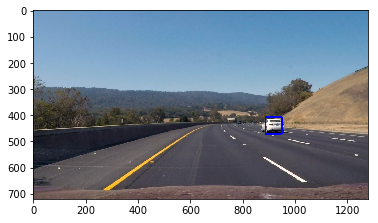

In [77]:
plt.imshow(output_img)
im = Image.fromarray(output_img)
im.save("output_images/output3.jpg")

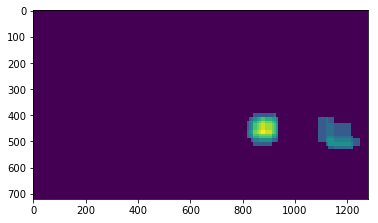

In [78]:
detectcar = mpimg.imread('test_images/test4.jpg')
output_img = findcar(detectcar, svc, X_scaler, testthreshold, vis = True)

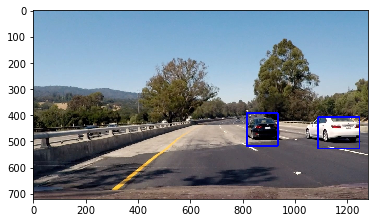

In [79]:
plt.imshow(output_img)
im = Image.fromarray(output_img)
im.save("output_images/output4.jpg")

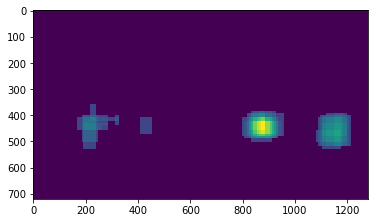

In [80]:
detectcar = mpimg.imread('test_images/test5.jpg')
output_img = findcar(detectcar, svc, X_scaler, testthreshold, vis = True)

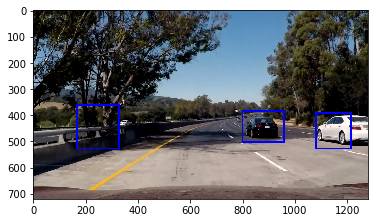

In [81]:
plt.imshow(output_img)
im = Image.fromarray(output_img)
im.save("output_images/output5.jpg")

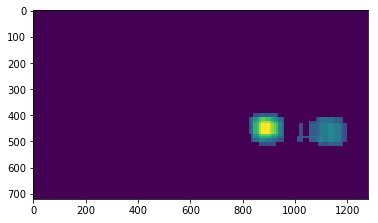

In [82]:
detectcar = mpimg.imread('test_images/test6.jpg')
output_img = findcar(detectcar, svc, X_scaler, testthreshold, vis = True)

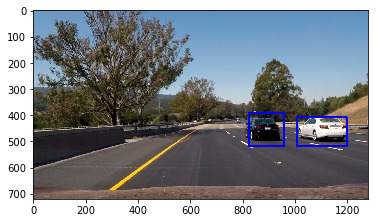

In [83]:
plt.imshow(output_img)
im = Image.fromarray(output_img)
im.save("output_images/output6.jpg")

From all of the above images, we can see that the heatmap and the actual output of the car detection. The "draw_labeled_bboxes" above create a box but filter out all the box that is too small since we know a physical car cannot be too small. That is why the heatmap may show a small box but the actual image does not detect a car in that region.

The file 'test_images/test5.jpg' show some false positive due to the tree shadow. This can be removed through video frame buffering and compare the frames and the boxes that was detected during video frame buffering.

Setting threshold to three for the heatmap look good to me.

In [84]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [86]:
def process_image(img):
    boxes = findcar(img, svc, X_scaler, testthreshold, getbox=True)
    process_image.square.append(boxes)
    
    if len(process_image.square) > process_image.buffer:
        del(process_image.square[0])
        
    if len(process_image.square) == process_image.buffer:
        h = np.zeros_like(img[:,:,0]).astype(np.float)
        
        for i in process_image.square:
            h = add_heat(h, i)

        h = apply_threshold(h, process_image.buffer-3)
        heatmap = np.clip(h, 0, 255)
        labels = label(heatmap)
        return draw_labeled_bboxes(img, labels)
    
    return draw_boxes(img, boxes)


process_image.buffer=12
process_image.square=[]

We basically call the "findcar" function for each video frame. And each frame, we detected some region that we believe a positive car is located. We buffer them together. In this case, the buffer size is 15. And we add up all these 15 frame's boxes like we did in the "findcar" function and determine the actual location of a car in the image.

In [87]:
if not os.path.exists("test_videos_output"):
    os.makedirs("test_videos_output")
    
project_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [24:15<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 24min, sys: 7.66 s, total: 24min 8s
Wall time: 24min 16s


In [88]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

Challenge And Improvement:

I found that processing each frame is very slow, the Histogram of Oriented Gradients is slow, sliding windows make it slower since there maybe a lot of windows. Especially we need to overlapping those windows to make sure we don't miss any car. We can have this improve by sliding our windows only within the lanes area, therefore the advantage lane detection can be used here. Using Support vector machine with a lot of windows size for sliding windows also slow it down. Maybe we can have convolutional neural network with a fixed predefined windows size. The training may take longer but it will be much quicker at run time. We want our self driving car to response as quick as possible.

I think the quality of training data is also very important. Improving the quality of the data for training can also avoid as much false positive as possible.